## Utility Functions

In [2]:
from datetime import datetime, timedelta
import json
from os.path import join
import re
from urllib.parse import urlparse


mention_finder = re.compile(r'@\w+ ?')
symbols_finder = re.compile(r'[^\w]')
def normalize_text(text):
    text = text.lower()
    if text.startswith('rt '):
        text = text[3:]
    text = mention_finder.sub('', text)
    text = symbols_finder.sub(' ', text)
    text = text.replace('  ', ' ')
    return text.strip()
_test_normalize_text = normalize_text('RT @xyz_ @opl Haha! Hoho!')
if _test_normalize_text != 'haha hoho':
    raise Exception("Not implemented correctly? '{0}'".format(_test_normalize_text))

DATASET_DATE = datetime(2018, 9, 1)

# Load the Media Bias/Fact Check db
with open(join('data', 'sources.json')) as infile:
    sources = json.load(infile)

FACTUAL_HALF = set(['MIXED', ''])
FACTUAL_COMPLETELY = set(['HIGH', 'VERY HIGH'])
DOMAIN_ALIASES = {
    'presstv.ir': 'presstv.com',
    'politi.co': 'politico.com',
}
FIREEYE_INAUTHENTIC_DOMAINS = set([
    'gahvare.com', 'yemenshia.com',
    'libertyfrontpress.com', 'institutomanquehue.org', 'criticschronicle.com',
    'usjournal.net', 'rpfront.com', 'britishleft.com'
])

## Reading the Dataset

In [3]:
import csv
import pandas as pd

with open(join("data","iranian_users.csv")) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    users = {row[2]: {'row': row, 'tweets': [], 'scores': None} for row in csvreader if row[0] != 'userid'}

tweet_texts = {}
repeated_texts = {}
    
tweet_counter = 0
missing_users = set([])
with open(join("data","iranian_tweets.csv")) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for tweet in csvreader:
        screen_name = tweet[3]
        if screen_name not in users:
            missing_users.add(screen_name)
        else:
            users[screen_name]['tweets'].append(tweet)
            tweet_counter += 1

        t = normalize_text(tweet[12])
        if len(t) < 5:
            continue
        if t not in tweet_texts:
            tweet_texts[t] = {screen_name: 1, '__total__': 1}
        elif screen_name not in tweet_texts[t]:
            tweet_texts[t][screen_name] = 1
            tweet_texts[t]['__total__'] += 1
        else:
            tweet_texts[t][screen_name] += 1
            tweet_texts[t]['__total__'] += 1

        if tweet_texts[t]['__total__'] > 4:
            repeated_texts[t] = tweet_texts[t]['__total__']

missing_users.remove('user_screen_name')
if missing_users:
    print("Missing users with tweets: " + ', '.join(list(not_in_sources)))
    print()

print("Loaded {tn} tweets from {un} users".format(tn=tweet_counter, un=len(users)))

Loaded 1122936 tweets from 770 users


## Calculating the Scores for Each User

### The Score Dimensions

#### Lack of Discretion
1. account_age: 0 -> most old one / 1 -> most recent one
2. created_in_a_busy_month: if created in a month where a lot of
other accounts in the dataset are created:
0.01 -> not a very busy month / 1 -> the month with maximum num of creations

#### Lack of Integrity
3. language_score: percentage of tweets in the same language as the interface
4. blank_bio: 0 -> has a bio! / 1 -> blank bio!

#### Usage of Automation
5. working_time_score: 0 -> tweets are distributed uniformly among the 24 hours
1 -> All the tweets are in a 8-hour window in different days
6. has_burst: 1 -> has tweeted more than once in a single second / 0 -> otherwise

#### Link to Suspicious Domains
7. links_to_low_factual_score: percentage of links in user's tweets to a domain
with not highly factual content, according to the Media Bias/Fact Check db
8. links_to_inauthentic_score: percentage of links in user's tweets to a domain
among the 'inauthentic' domain according to the FireEye report

#### Pushing a Message
9. retweets_percentage: 1 -> all the tweets by the user is retweets / 0 -> none
10. repeated_percentage: 1 -> all the tweets by the user is repeated by the user / 0 -> none
11. spreading_a_tweet_percentage: 1 -> all the tweets are among highly repeated ones
/ 0 -> none of them ...

In [14]:
not_in_sources = set([])
dataset_sources_factuality = {}


users_with_no_tweet = set([])
max_account_age = None
min_account_age = None

creation_month_bins = {}
busiest_month = 0
for _, profile in users.items():
    if profile['row'][8][:7] not in creation_month_bins:
        creation_month_bins[profile['row'][8][:7]] = 1
    else:
        creation_month_bins[profile['row'][8][:7]] += 1
    if creation_month_bins[profile['row'][8][:7]] > busiest_month:
        busiest_month = creation_month_bins[profile['row'][8][:7]]
    

user_counter = 0
for screen_name, profile in users.items():
    n = len(profile['tweets'])

    interface_language = profile['row'][9].lower()[:2]
    account_age = (DATASET_DATE - datetime.strptime(profile['row'][8], '%Y-%m-%d')).days
    if not max_account_age or max_account_age < account_age:
        max_account_age = account_age
    if not min_account_age or min_account_age > account_age:
        min_account_age = account_age

    if n == 0:
        users_with_no_tweet.add(screen_name)
        profile['scores'] = None
        continue

    language_score_unmatched = 0
    tweet_time_bin = [0] * 24
    links = 0
    links_to_low_factual = 0
    links_to_inauthentic = 0
    has_burst = False
    tweet_timestamps = {}
    retweets = 0
    self_repetition = 0
    spreading_a_tweet = 0
    for tweet in profile['tweets']:
        if tweet[11][:2].lower() != interface_language:
            language_score_unmatched += 1

        tweet_timestamp = tweet[13]
        if tweet_timestamp not in tweet_timestamps:
            tweet_timestamps[tweet_timestamp] = 1
        else:
            tweet_timestamps[tweet_timestamp] += 1
            has_burst = True

        tweet_time = datetime.strptime(tweet_timestamp, '%Y-%m-%d %H:%M')
        tweet_time_bin[tweet_time.hour] += 1

        if tweet[12][:3].lower() == 'rt ':
            retweets += 1

        t = normalize_text(tweet[12])
        if len(t) >= 5:
            if tweet_texts[t][screen_name] > 1:
                self_repetition += 1
            if t in repeated_texts:
                spreading_a_tweet += 1

        urls = tweet[-3][2:-2].split()
        for url in urls:
            domain = urlparse(url).netloc.lower()
            if domain:
                links += 1
            d1 = d2 = domain    

            if d1 not in sources and d1.count('.') > 1:
                d1 = d1[d1.index('.')+1:]
            if d1 not in sources and d1 in DOMAIN_ALIASES:
                d1 = DOMAIN_ALIASES[d1]
            if d1 not in sources and d1.count('.') > 1:
                d1 = 'www.' + d1
            if d1 not in sources:
                not_in_sources.add(d1)
            else:
                factual = sources[d1][0]['factual']
                if factual not in dataset_sources_factuality:
                    dataset_sources_factuality[factual] = 1
                else:
                    dataset_sources_factuality[factual] += 1
                if factual in FACTUAL_HALF:
                    links_to_low_factual += 0.5
                elif factual not in FACTUAL_COMPLETELY:
                    links_to_low_factual += 1

            if d2 not in FIREEYE_INAUTHENTIC_DOMAINS and d2.count('.') > 1:
                d2 = d2[d2.index('.')+1:]
            if d2 in FIREEYE_INAUTHENTIC_DOMAINS:
                links_to_inauthentic += 1

    max_sliding_time_window = 0
    max_sliding_time_window_sum = 0
    for i in range(24):
        sliding_time_window_sum = sum(tweet_time_bin[i:(i+8) % 24])
        if sliding_time_window_sum > max_sliding_time_window_sum:
            max_sliding_time_window_sum = sliding_time_window_sum
            max_sliding_time_window = i

    # Normalization
    created_in_a_busy_month = creation_month_bins[profile['row'][8][:7]] / busiest_month
    language_score = language_score_unmatched / n
    working_time_score = ((max_sliding_time_window_sum / n) - (1/3)) * 3 / 2
    if links > 0:
        links_to_low_factual_score = links_to_low_factual / links
        links_to_inauthentic_score = links_to_inauthentic / links
    else:
        links_to_low_factual_score = 0
        links_to_inauthentic_score = 0

    profile['scores'] = [
        # Lack of Discretion
        account_age,  # Will be normalized outside this loop
        created_in_a_busy_month,

        # Lack of Integrity
        language_score,
        0 if profile['row'][4] else 1,

        # Usage of Automation
        working_time_score,
        1 if has_burst else 0,

        # Link to Suspicious Domains
        links_to_low_factual_score,
        links_to_inauthentic_score,
        
        # Pushing a Message
        retweets / n,
        self_repetition / n,
        spreading_a_tweet / n,
    ]

    last_tweet_timestamp = tweet[13]

#     if user_counter == 64:
#         break
    user_counter += 1

user_counter = 0
for screen_name, profile in users.items():
    if profile['scores']:
        if max_account_age and min_account_age and max_account_age > min_account_age:
            profile['scores'][0] = (max_account_age - profile['scores'][0]) / (max_account_age - min_account_age)

        score = sum(profile['scores'])
        profile['score'] = score
        print('{name:16}: {score:6.2f} = ({vector})'.format(
            name=screen_name[:16], score=score, vector=' '.join(['{0:3.1f}'.format(v) for v in profile['scores']])))

#         if user_counter == 64:
#             break
        user_counter += 1

print()
print("{num} users are suspended without having any tweets in the dataset: {list}".format(
    num=len(users_with_no_tweet), list=', '.join([s[:16] for s in users_with_no_tweet])))
print()
print("{n} domains not in the Media Bias/Fact Check db: ".format(
    n=len(not_in_sources)))
# ls=', '.join(list(not_in_sources)))
print()
print("Overall factuality of the links in the tweets:" + str(dataset_sources_factuality))


57e2082d64baa89d:   5.46 = (0.9 1.0 1.0 0.0 0.5 1.0 0.0 0.1 0.4 0.6 0.0)
11891c406c088fdd:   3.39 = (0.5 0.1 0.1 0.0 1.0 1.0 0.0 0.0 0.5 0.1 0.1)
5ddbd530097789a4:   7.21 = (0.9 0.7 0.2 1.0 0.4 1.0 0.0 0.8 1.0 0.2 1.0)
50012d5e4f959a3d:   3.80 = (0.7 0.5 0.2 0.0 0.5 1.0 0.1 0.0 0.9 0.0 0.0)
28478f20c217a672:   5.52 = (0.9 0.8 1.0 0.0 0.8 1.0 0.0 0.0 0.9 0.0 0.1)
260bbf8c9ca24c63:   4.45 = (0.9 1.0 1.0 0.0 0.6 1.0 0.0 0.0 0.0 0.0 0.0)
3f1a40fa0636db86:   5.00 = (0.9 0.7 1.0 0.0 0.4 1.0 0.0 0.0 0.7 0.0 0.3)
bc2adb39c920650d:   4.72 = (0.9 0.7 1.0 0.0 0.7 1.0 0.0 0.0 0.4 0.0 0.0)
fd01dd625797c4f4:   4.29 = (0.9 0.6 1.0 0.0 0.6 1.0 0.0 0.0 0.2 0.1 0.0)
2d761afd8c25c25e:   5.79 = (0.9 0.8 1.0 0.0 0.5 1.0 0.0 0.0 0.7 0.1 0.6)
f3776839f137b8fd:   4.55 = (0.7 0.3 1.0 0.0 0.6 1.0 0.0 0.0 0.9 0.0 0.1)
c2577510f436a286:   4.91 = (0.9 1.0 1.0 0.0 0.6 1.0 0.0 0.0 0.5 0.0 0.0)
0669e7730d2cacb6:   4.67 = (1.0 0.2 1.0 0.0 0.6 1.0 0.0 0.0 0.9 0.0 0.1)
67179a5165a72056:   3.91 = (0.8 0.1 1.0 0.0 1.0 0.0

## Visualization

### The Features

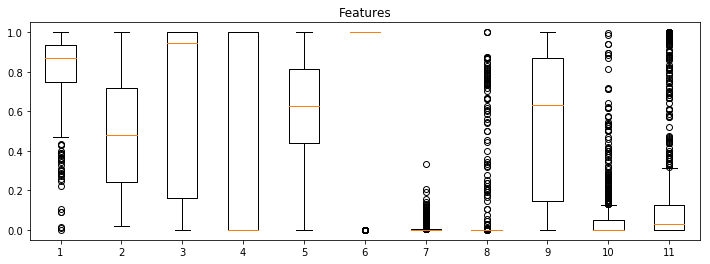

In [15]:
import matplotlib.pyplot as plt

data = [[p['scores'][i] for p in users.values() if 'score' in p] for i in range(11)]
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title('Features')
ax.boxplot(data)

plt.show()

### Correlations

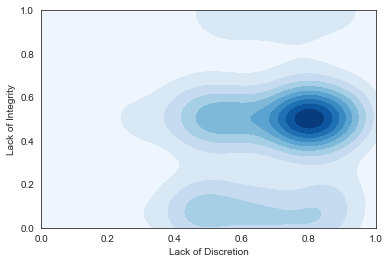

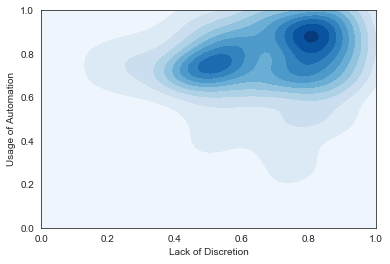

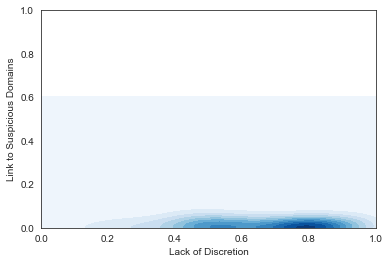

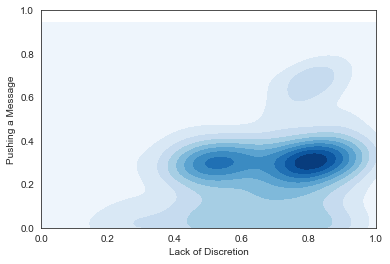

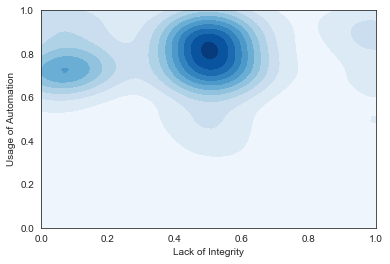

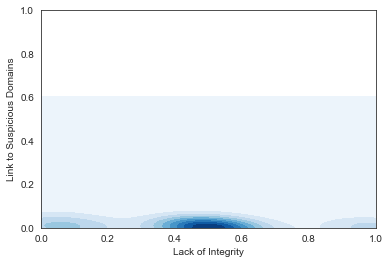

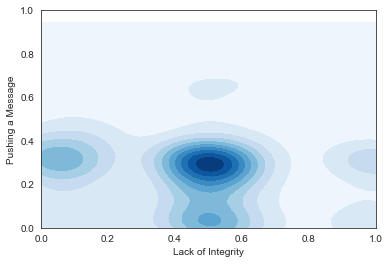

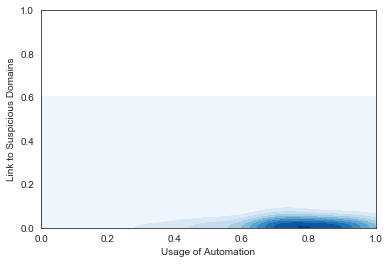

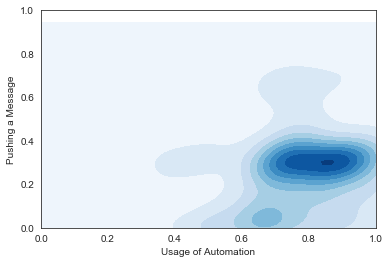

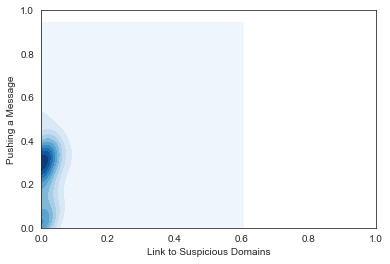

In [23]:
ordered_users = [(n, p) for n, p in users.items() if 'score' in p]

l_o_d = [(p['scores'][0] + p['scores'][1]) / 2 for n, p in ordered_users]
l_o_i = [(p['scores'][2] + p['scores'][3]) / 2 for n, p in ordered_users]
u_o_a = [(p['scores'][4] + p['scores'][5]) / 2 for n, p in ordered_users]
s_d = [(p['scores'][6] + p['scores'][7]) / 2 for n, p in ordered_users]
p_m = [(p['scores'][8] + p['scores'][9] + p['scores'][10]) / 3 for n, p in ordered_users]

import seaborn as sns


sns.set_style("white")
ax = sns.kdeplot(
    l_o_d, l_o_i,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Discretion")
ax.set_xlim(0, 1)
ax.set_ylabel("Lack of Integrity")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_d, u_o_a,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Discretion")
ax.set_xlim(0, 1)
ax.set_ylabel("Usage of Automation")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_d, s_d,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Discretion")
ax.set_xlim(0, 1)
ax.set_ylabel("Link to Suspicious Domains")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_d, p_m,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Discretion")
ax.set_xlim(0, 1)
ax.set_ylabel("Pushing a Message")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_i, u_o_a,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Integrity")
ax.set_xlim(0, 1)
ax.set_ylabel("Usage of Automation")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_i, s_d,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Integrity")
ax.set_xlim(0, 1)
ax.set_ylabel("Link to Suspicious Domains")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    l_o_i, p_m,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Lack of Integrity")
ax.set_xlim(0, 1)
ax.set_ylabel("Pushing a Message")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    u_o_a, s_d,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Usage of Automation")
ax.set_xlim(0, 1)
ax.set_ylabel("Link to Suspicious Domains")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    u_o_a, p_m,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Usage of Automation")
ax.set_xlim(0, 1)
ax.set_ylabel("Pushing a Message")
ax.set_ylim(0, 1)
plt.show()
plt.close()


sns.set_style("white")
ax = sns.kdeplot(
    s_d, p_m,
    cmap="Blues", shade=True, shade_lowest=True, )
ax.set_xlabel("Link to Suspicious Domains")
ax.set_xlim(0, 1)
ax.set_ylabel("Pushing a Message")
ax.set_ylim(0, 1)
plt.show()
plt.close()


## Experiment: Clustering

In [16]:
from sklearn.cluster import KMeans

labels = {}

kmeans = KMeans(n_clusters=4)
kmeans.fit([profile['scores'] for profile in users.values() if profile['scores']])
for profile in users.values():
    if profile['scores']:
        label = int(kmeans.predict([profile['scores']]))
        if label not in labels:
            labels[label] = [profile]
        else:
            labels[label].append(profile)

for label, profiles in labels.items():
    print("{num} users in cluser {label}:".format(num=len(profiles), label=label))
    print('\n'.join(['{name:16}: {vector}'.format(name=p['row'][2][:16], vector=' '.join(['{0:3.1f}'.format(v) for v in p['scores']])) for p in profiles]))
    print()


252 users in cluser 0:
57e2082d64baa89d: 0.9 1.0 1.0 0.0 0.5 1.0 0.0 0.1 0.4 0.6 0.0
28478f20c217a672: 0.9 0.8 1.0 0.0 0.8 1.0 0.0 0.0 0.9 0.0 0.1
260bbf8c9ca24c63: 0.9 1.0 1.0 0.0 0.6 1.0 0.0 0.0 0.0 0.0 0.0
3f1a40fa0636db86: 0.9 0.7 1.0 0.0 0.4 1.0 0.0 0.0 0.7 0.0 0.3
bc2adb39c920650d: 0.9 0.7 1.0 0.0 0.7 1.0 0.0 0.0 0.4 0.0 0.0
fd01dd625797c4f4: 0.9 0.6 1.0 0.0 0.6 1.0 0.0 0.0 0.2 0.1 0.0
2d761afd8c25c25e: 0.9 0.8 1.0 0.0 0.5 1.0 0.0 0.0 0.7 0.1 0.6
f3776839f137b8fd: 0.7 0.3 1.0 0.0 0.6 1.0 0.0 0.0 0.9 0.0 0.1
c2577510f436a286: 0.9 1.0 1.0 0.0 0.6 1.0 0.0 0.0 0.5 0.0 0.0
0669e7730d2cacb6: 1.0 0.2 1.0 0.0 0.6 1.0 0.0 0.0 0.9 0.0 0.1
freesaudiawomen : 0.8 0.2 1.0 0.0 0.4 1.0 0.0 0.0 0.9 0.1 0.1
3c536b8d54ca334c: 0.9 0.3 1.0 0.0 0.3 1.0 0.0 0.0 0.0 0.0 0.0
a3d8eccd0b8b2cec: 0.8 0.6 1.0 0.0 0.8 1.0 0.0 0.0 0.2 0.2 0.1
254403684f5a792b: 0.8 0.2 1.0 0.0 0.5 1.0 0.0 0.0 0.2 0.0 0.0
507cb5a10918355e: 0.9 0.8 1.0 0.0 0.6 1.0 0.0 0.0 0.9 0.0 0.5
alsaudiatimes   : 0.7 0.2 1.0 0.0 0.2 1.0 0.0 0